<a href="https://colab.research.google.com/github/timuriz/ObjectSegmentationMarsWS25/blob/main/path_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations==1.4.6 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 8.1 MB/s eta 0:00:00


In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.models.segmentation as models
import torch.nn as nn
import torch

In [38]:
class RoadBaseDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        # список имён файлов картинок
        self.image_names = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, name)
        mask_path = os.path.join(self.masks_dir, name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))
        return image, mask

In [40]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

IMG_SIZE = 768

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    # Removed: HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

class IndexedRoadDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset      # ВАЖНО: здесь будет RoadBaseDataset
        self.indices = indices                # список индексов (train или val)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        name = self.base_dataset.image_names[idx]

        img_path = os.path.join(self.base_dataset.images_dir, name)
        mask_path = os.path.join(self.base_dataset.masks_dir, name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        # For multi-class segmentation, masks should contain class indices (0, 1, 2, 3).
        # The `(mask > 0).astype("float32")` line is removed as it converts to binary.
        # Convert mask to int64 for proper handling by ToTensorV2 as class labels.
        mask = mask.astype(np.int64)

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"].float()
        # Convert mask to LongTensor, as CrossEntropyLoss expects target labels as LongTensor.
        # ToTensorV2 for masks typically returns (H, W) for grayscale masks, so no unsqueeze(0) needed for multi-class CE loss.
        mask  = augmented["mask"].long()

        return image, mask

In [41]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

IMG_SIZE = 768

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # Replaced ShiftScaleRotate with Affine to address UserWarning
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.0625, 0.0625), rotate=(-45, 45), p=0.5, interpolation=1, mask_interpolation=0),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

class IndexedRoadDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset      # ВАЖНО: здесь будет RoadBaseDataset
        self.indices = indices                # список индексов (train или val)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        name = self.base_dataset.image_names[idx]

        img_path = os.path.join(self.base_dataset.images_dir, name)
        mask_path = os.path.join(self.base_dataset.masks_dir, name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        # For multi-class segmentation, masks should contain class indices (0, 1, 2, 3).
        # The `(mask > 0).astype("float32")` line is removed as it converts to binary.
        # Convert mask to int64 for proper handling by ToTensorV2 as class labels.
        mask = mask.astype(np.int64)

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"].float()
        # Convert mask to LongTensor, as CrossEntropyLoss expects target labels as LongTensor.
        # ToTensorV2 for masks typically returns (H, W) for grayscale masks, so no unsqueeze(0) needed for multi-class CE loss.
        mask  = augmented["mask"].long()

        return image, mask

In [48]:
images_dir = "/content/drive/MyDrive/ML/images_last_clean_dataset"
masks_dir  = "/content/drive/MyDrive/ML/masks_dataset_last_clean_dataset"

# 1) создаём базовый датасет
base_dataset = RoadBaseDataset(images_dir, masks_dir)

print("len(base_dataset):", len(base_dataset))

# тест базового датасета
img0, m0 = base_dataset[0]
print("base_dataset[0] image:", type(img0), img0.shape)
print("base_dataset[0] mask: ", type(m0),  m0.shape)

# 2) делим индексы вручную на train/val
n = 200 # Limiting to 100 images
n_train = int(0.8 * n)
indices = list(range(n))

train_indices = indices[:n_train]
val_indices   = indices[n_train:]

print("train_indices:", train_indices)
print("val_indices:  ", val_indices)

# 3) создаём train/val датасеты с трансформами
train_ds = IndexedRoadDataset(base_dataset, train_indices, train_transform)
val_ds   = IndexedRoadDataset(base_dataset, val_indices,   val_transform)

print("len(train_ds):", len(train_ds))
print("len(val_ds):  ", len(val_ds))

# тест train_ds
img1, m1 = train_ds[0]
print("train_ds[0] image:", img1.shape)
print("train_ds[0] mask: ", m1.shape)

# 4) DataLoader'ы
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=0)

len(base_dataset): 674
base_dataset[0] image: <class 'numpy.ndarray'> (512, 512, 3)
base_dataset[0] mask:  <class 'numpy.ndarray'> (512, 512)
train_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
val_indices:   [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 1

In [43]:
pip install torch torchvision

In [49]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [50]:
def create_model():
    # загружаем предобученную модель
    model = models.deeplabv3_resnet50(weights=models.DeepLabV3_ResNet50_Weights.DEFAULT)

    # заменяем финальный слой: 256 каналов -> 4 (для 4 классов)
    model.classifier[4] = nn.Conv2d(256, 4, kernel_size=1) # Changed from 1 to 4 output channels

    return model

model = create_model().to(device)

In [46]:
# For multi-class segmentation, nn.CrossEntropyLoss is typically used.
# It combines LogSoftmax and NLLLoss, expecting raw logits and target class indices.
cross_entropy_loss = nn.CrossEntropyLoss()

def loss_fn(outputs, masks):
    # CrossEntropyLoss expects inputs of shape (N, C, H, W) and targets of shape (N, H, W).
    return cross_entropy_loss(outputs, masks)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [51]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = loss_fn(outputs, masks)

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

In [53]:
import torch.optim.lr_scheduler

# For multi-class segmentation, nn.CrossEntropyLoss is typically used.
# It combines LogSoftmax and NLLLoss, expecting raw logits and target class indices.
cross_entropy_loss = nn.CrossEntropyLoss()

def loss_fn(outputs, masks):
    # CrossEntropyLoss expects inputs of shape (N, C, H, W) and targets of shape (N, H, W).
    return cross_entropy_loss(outputs, masks)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = eval_one_epoch(model, val_loader, loss_fn, device)

    scheduler.step(val_loss) # Call scheduler.step() with the validation loss

    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f} | lr: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/50 | train loss: 0.8431 | val loss: 0.5327 | lr: 0.000200
Epoch 2/50 | train loss: 0.6310 | val loss: 0.6811 | lr: 0.000200
Epoch 3/50 | train loss: 0.6649 | val loss: 3.4993 | lr: 0.000200
Epoch 4/50 | train loss: 0.6393 | val loss: 0.4768 | lr: 0.000200
Epoch 5/50 | train loss: 0.5884 | val loss: 0.5739 | lr: 0.000200
Epoch 6/50 | train loss: 0.6046 | val loss: 0.3992 | lr: 0.000200
Epoch 7/50 | train loss: 0.5309 | val loss: 0.5368 | lr: 0.000200
Epoch 8/50 | train loss: 0.5595 | val loss: 0.2914 | lr: 0.000200
Epoch 9/50 | train loss: 0.4986 | val loss: 0.3508 | lr: 0.000200
Epoch 10/50 | train loss: 0.5500 | val loss: 0.9495 | lr: 0.000200
Epoch 11/50 | train loss: 0.5533 | val loss: 0.2813 | lr: 0.000200
Epoch 12/50 | train loss: 0.4993 | val loss: 0.3238 | lr: 0.000200
Epoch 13/50 | train loss: 0.5335 | val loss: 0.2805 | lr: 0.000200
Epoch 14/50 | train loss: 0.4447 | val loss: 0.2928 | lr: 0.000200
Epoch 15/50 | train loss: 0.4561 | val loss: 0.2831 | lr: 0.000200


=== Sample 0 ===


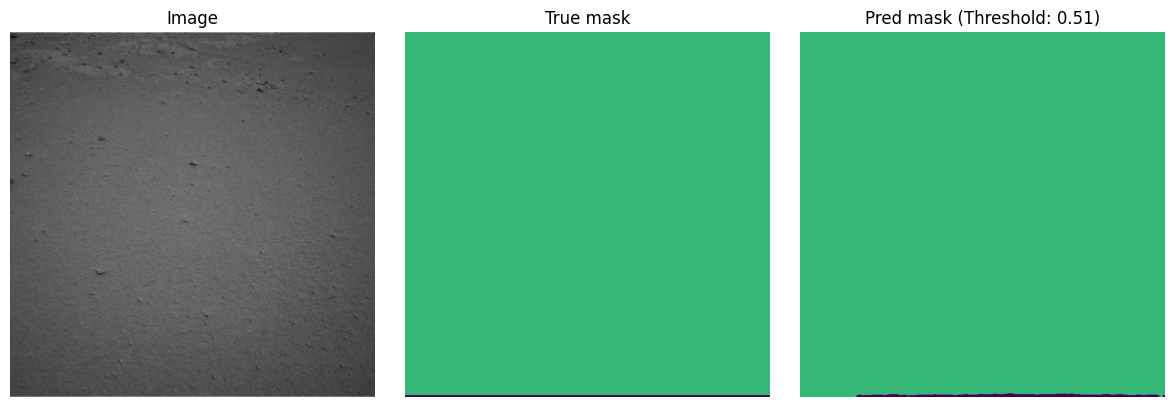

=== Sample 1 ===


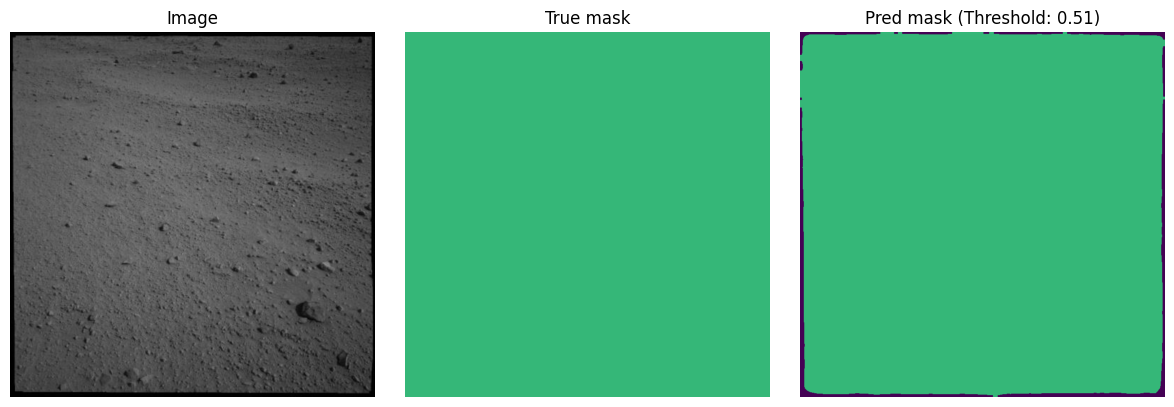

=== Sample 2 ===


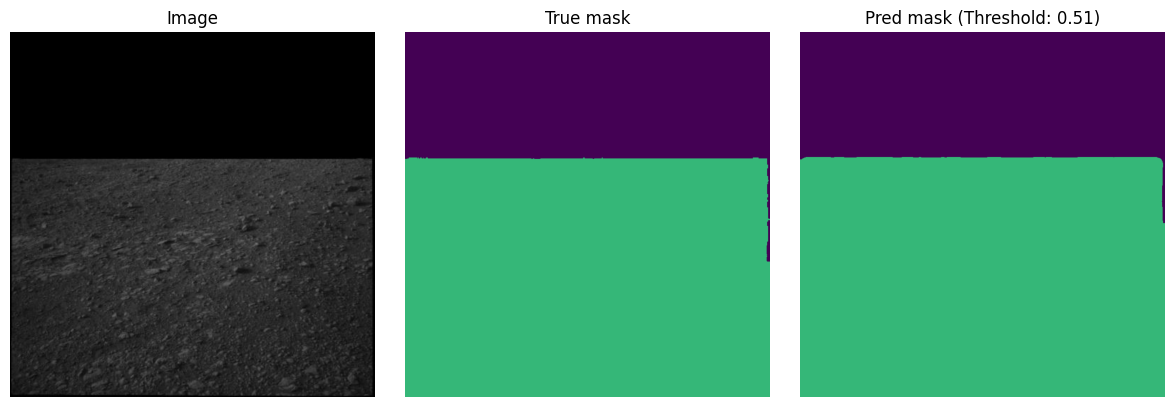

=== Sample 3 ===


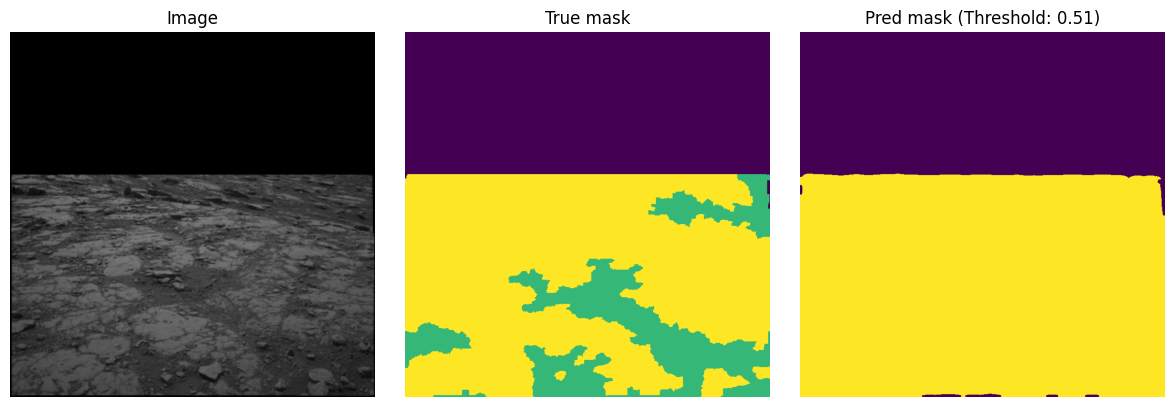

=== Sample 4 ===


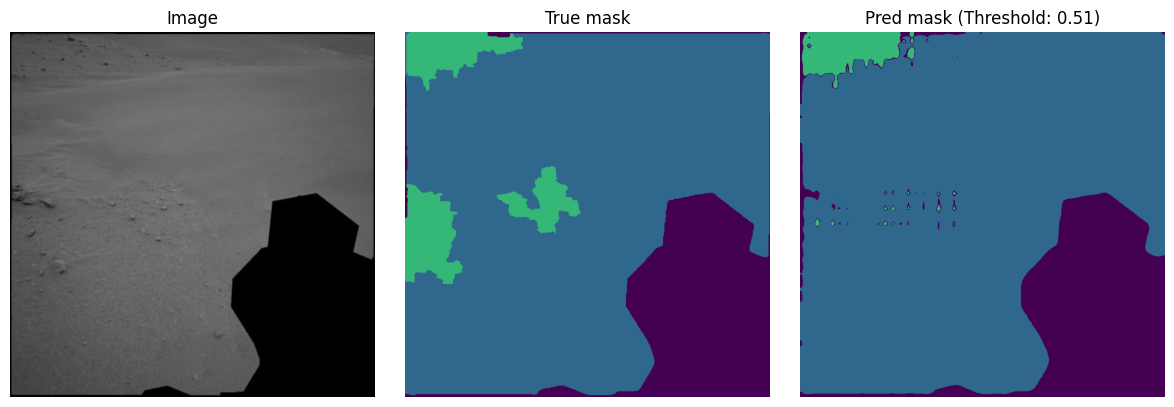

=== Sample 5 ===


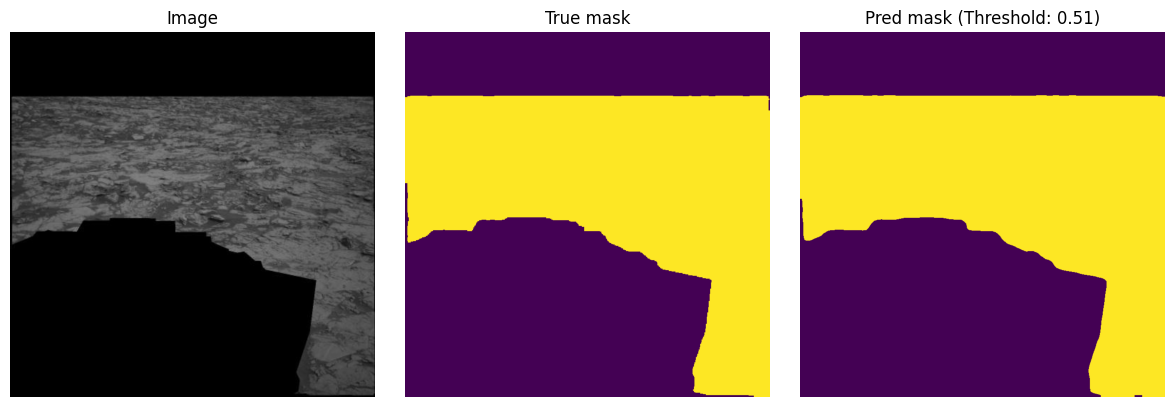

=== Sample 6 ===


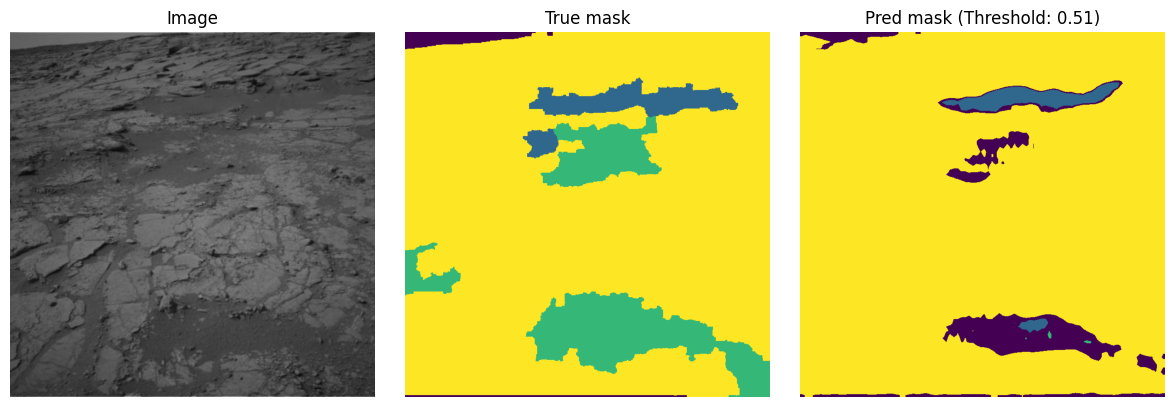

=== Sample 7 ===


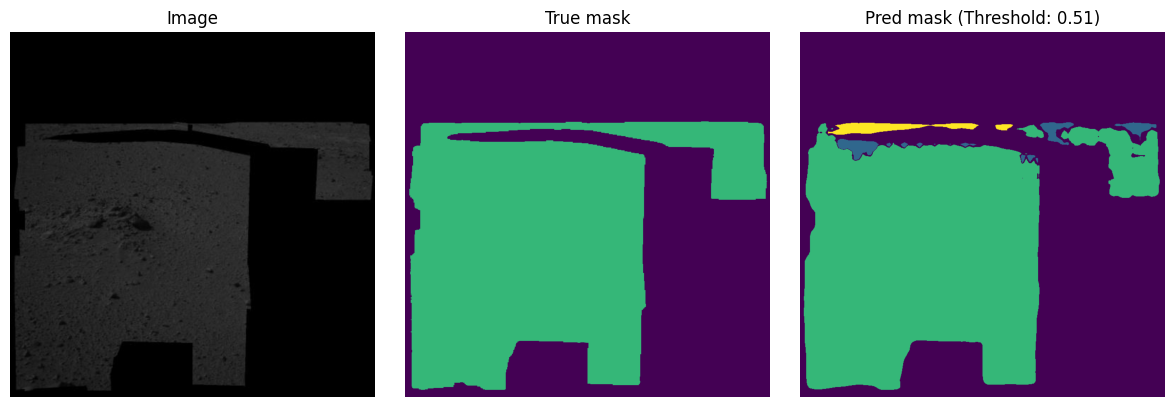

=== Sample 8 ===


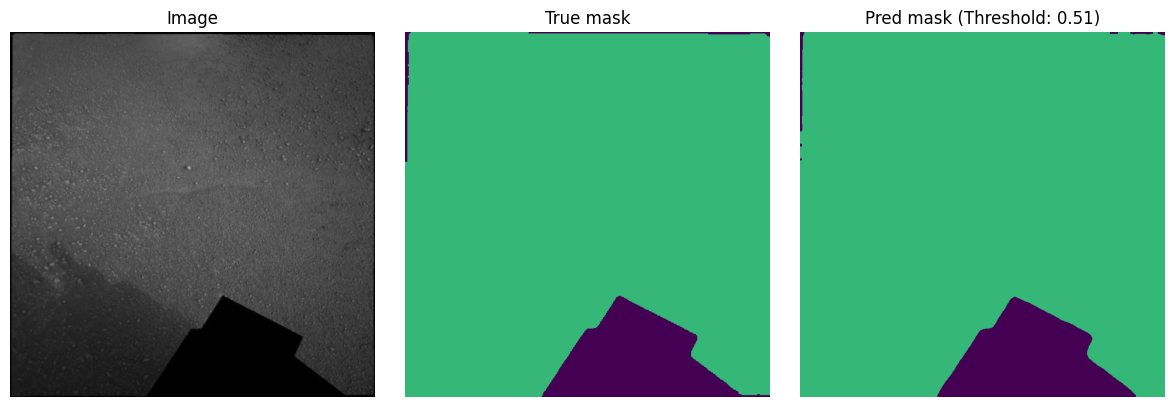

=== Sample 9 ===


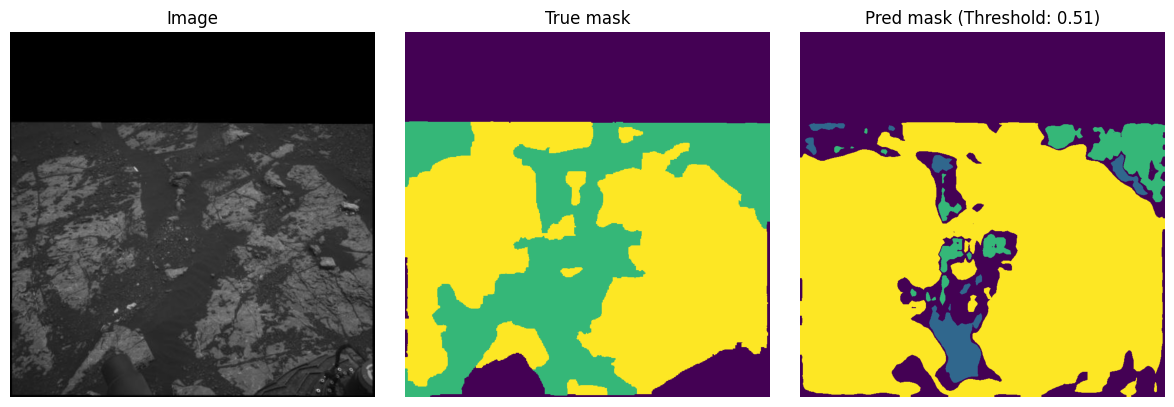

=== Sample 10 ===


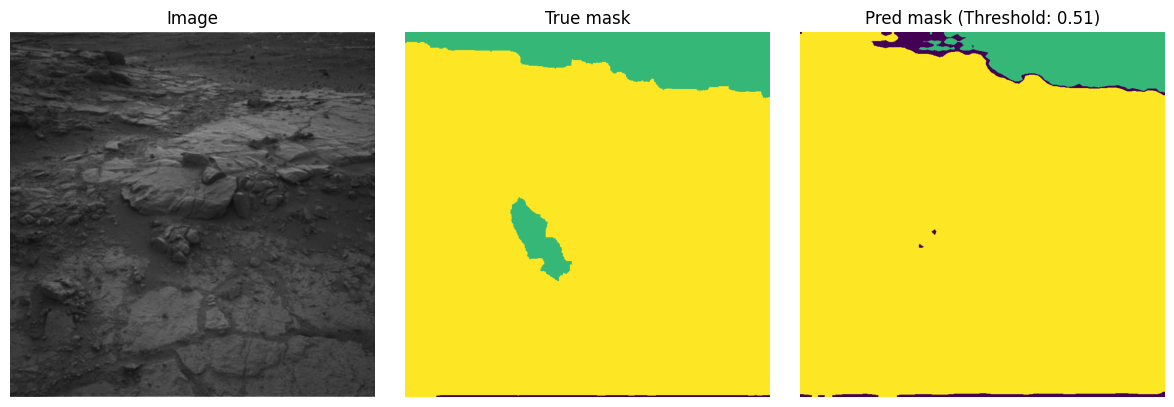

=== Sample 11 ===


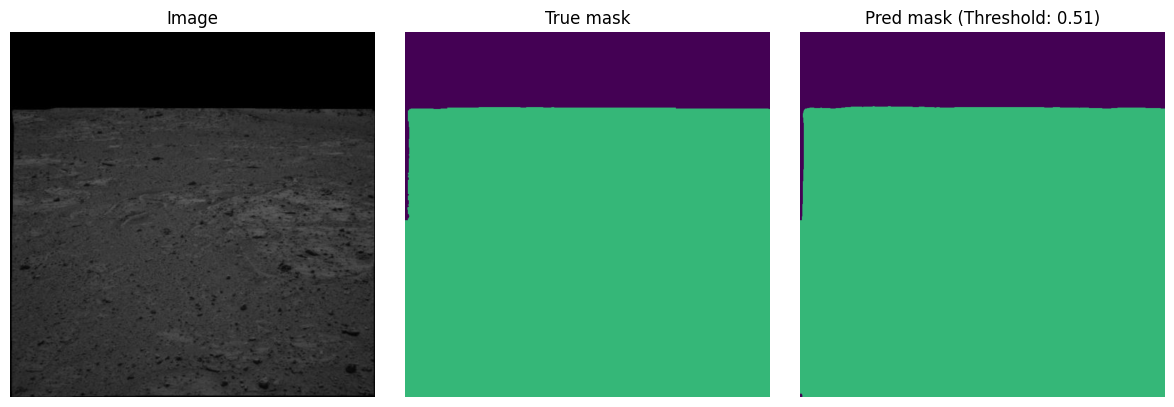

=== Sample 12 ===


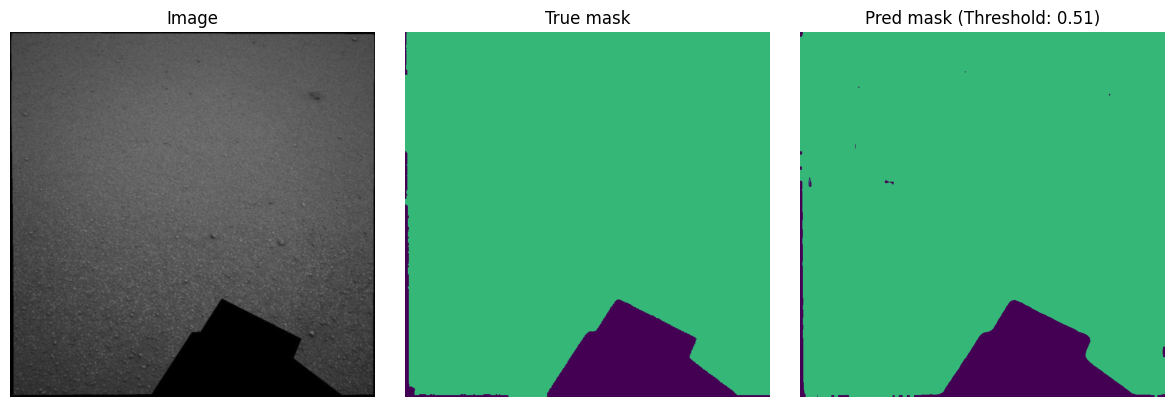

=== Sample 13 ===


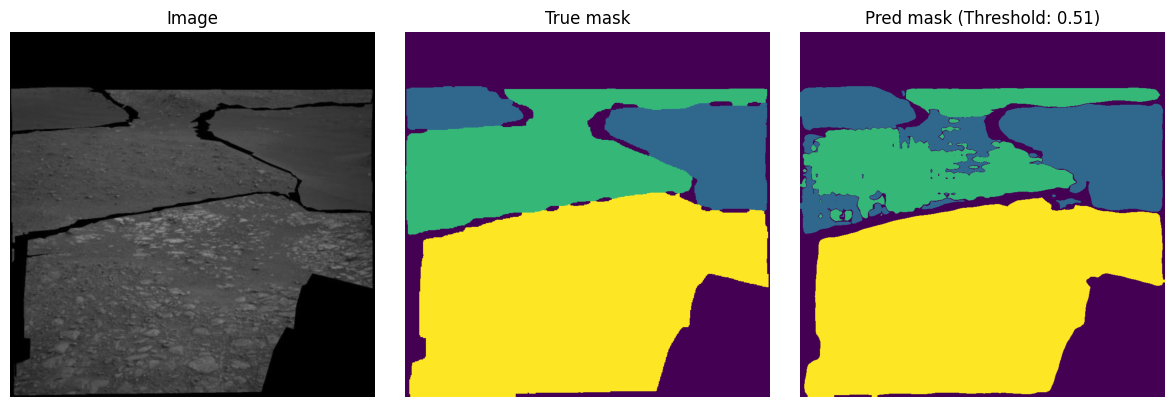

=== Sample 14 ===


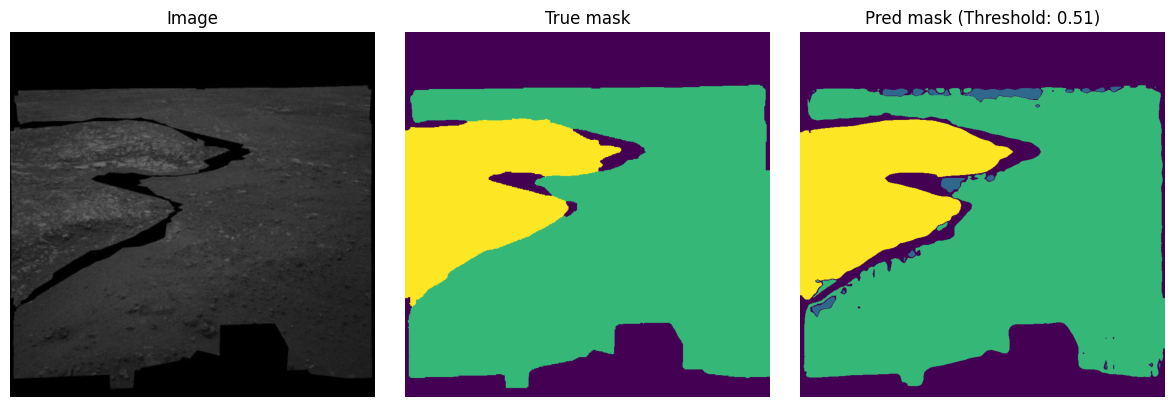

=== Sample 15 ===


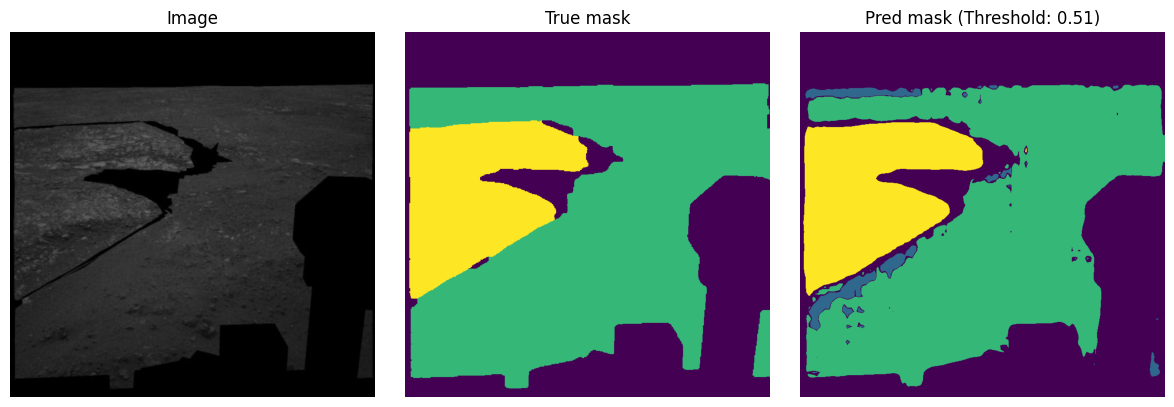

=== Sample 16 ===


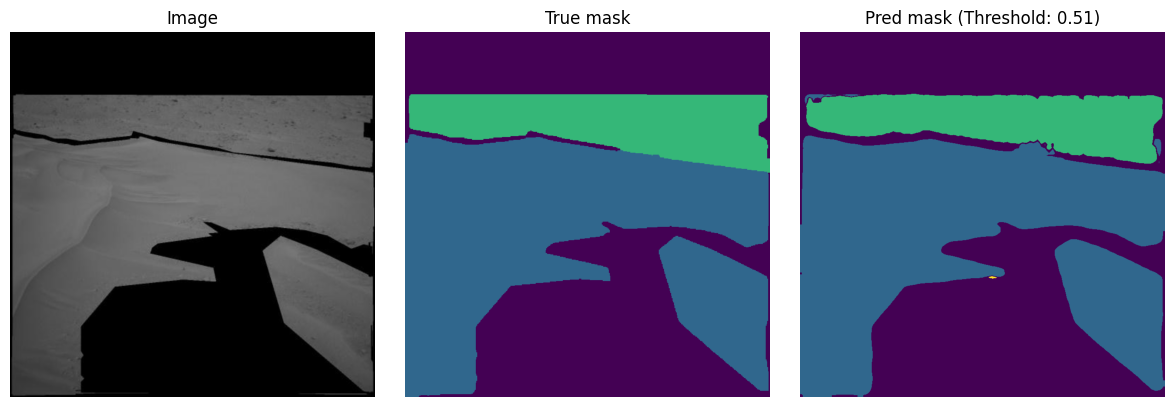

=== Sample 17 ===


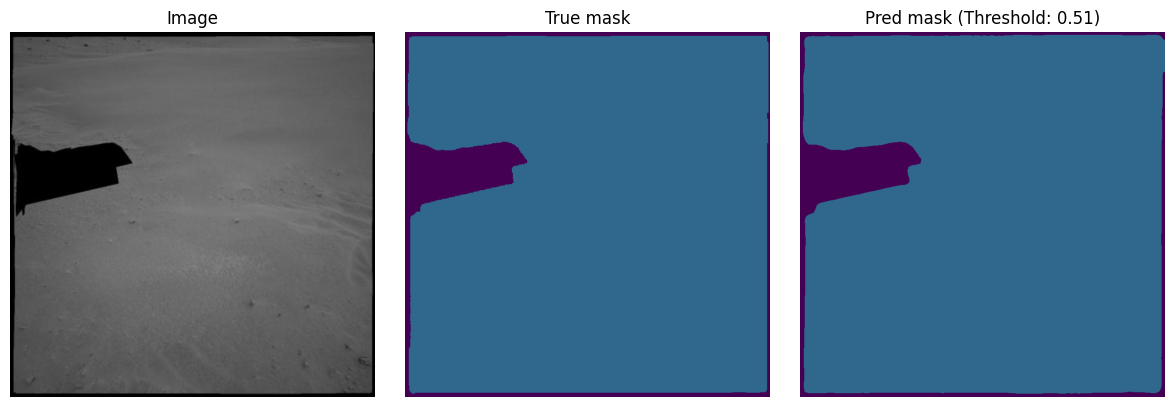

=== Sample 18 ===


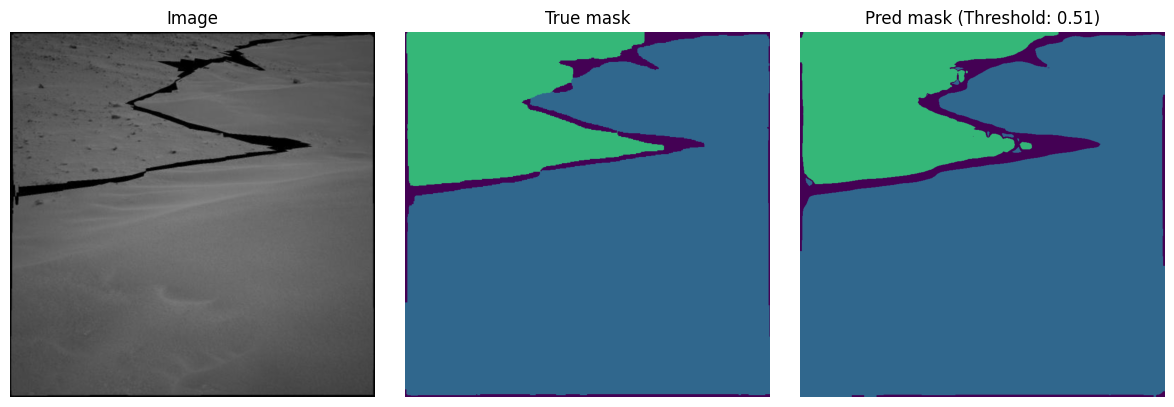

=== Sample 19 ===


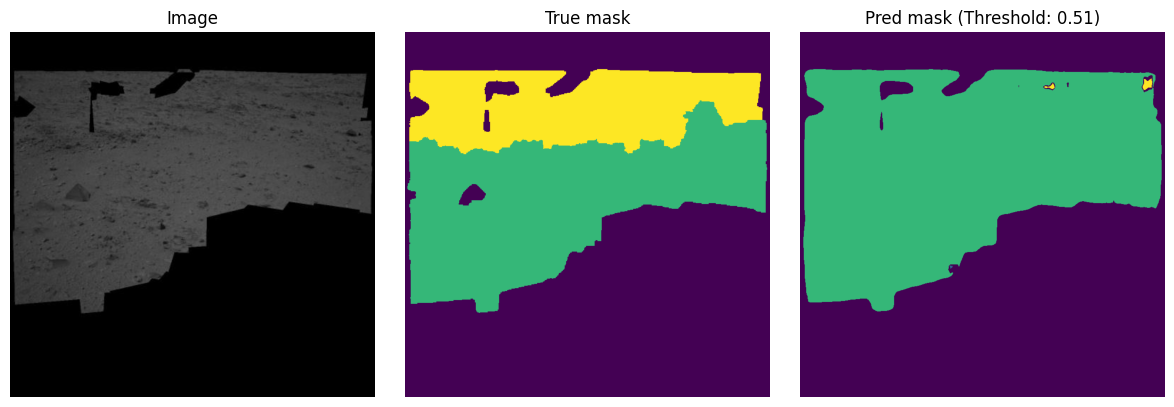

=== Sample 20 ===


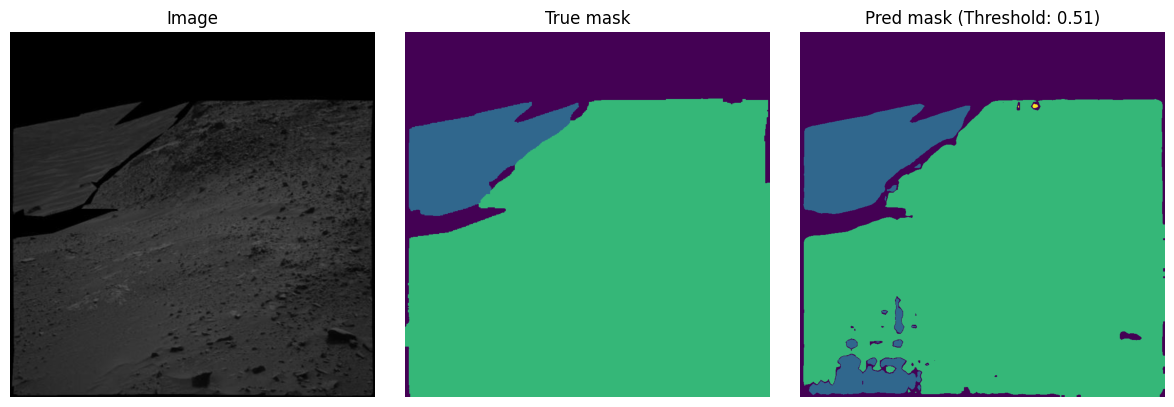

=== Sample 21 ===


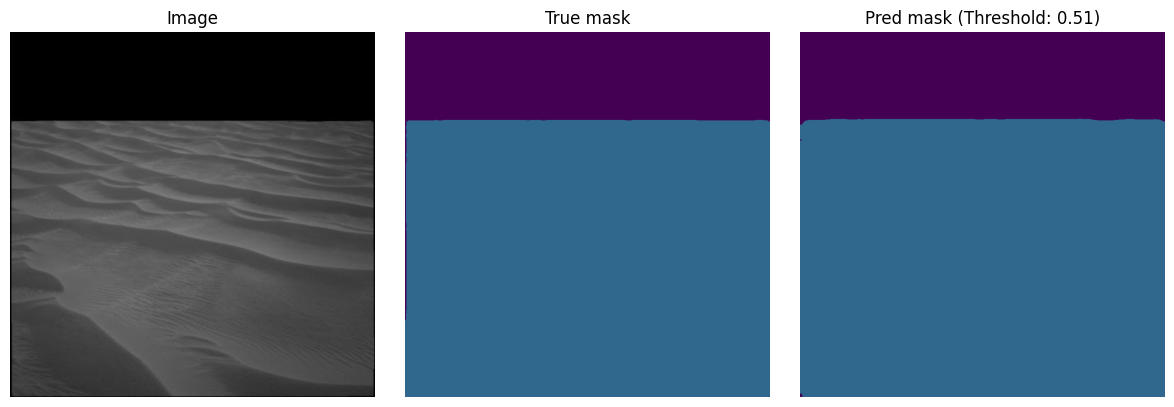

=== Sample 22 ===


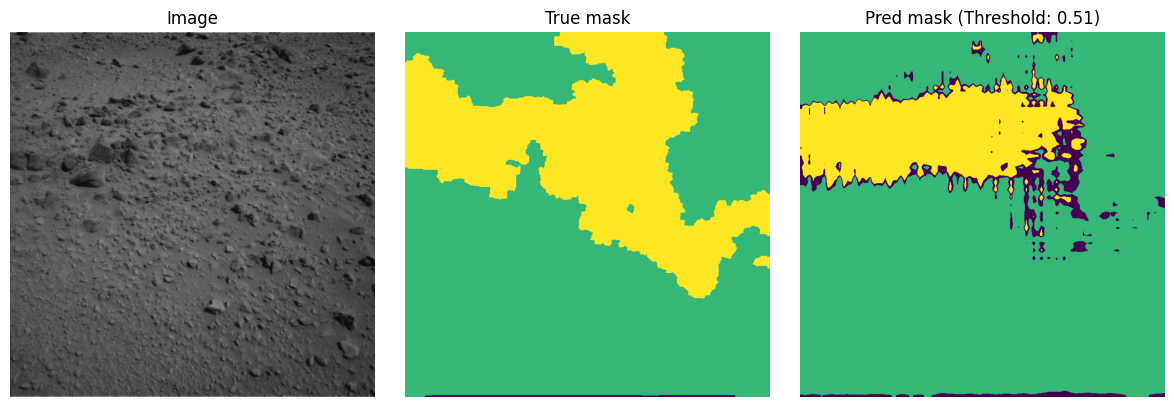

=== Sample 23 ===


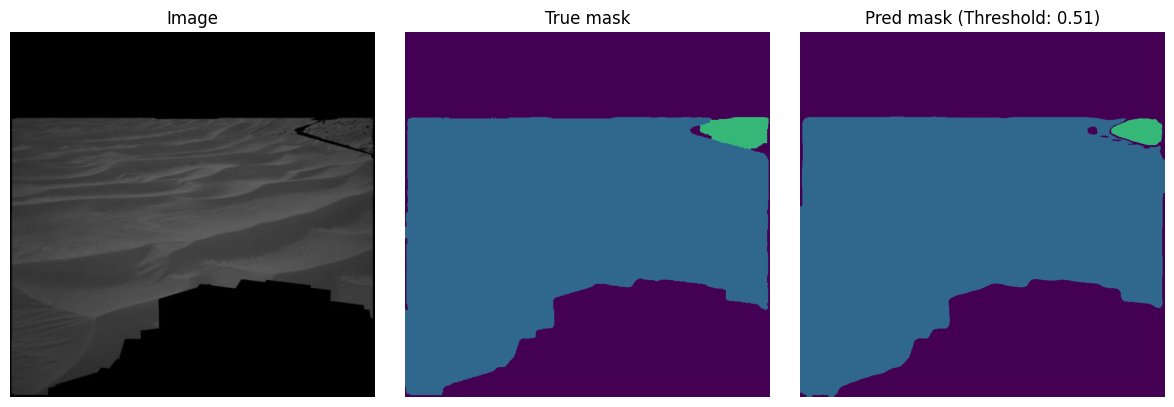

=== Sample 24 ===


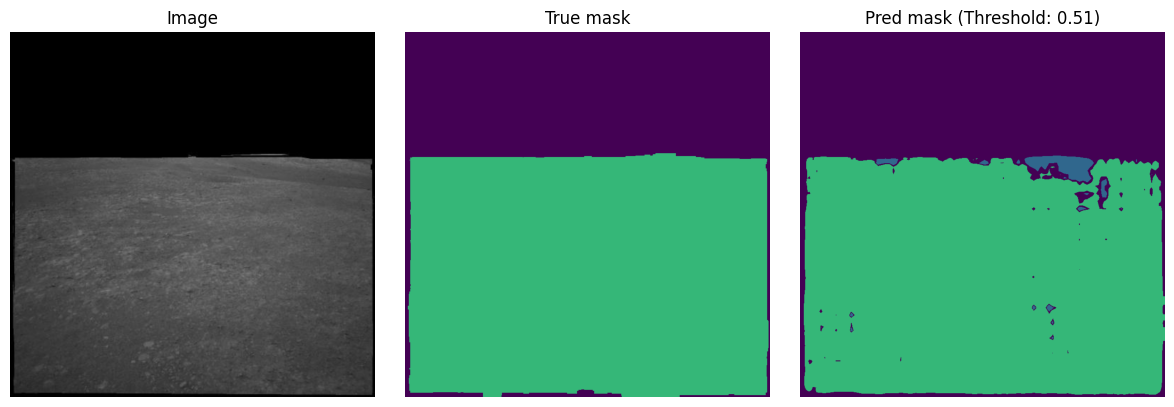

=== Sample 25 ===


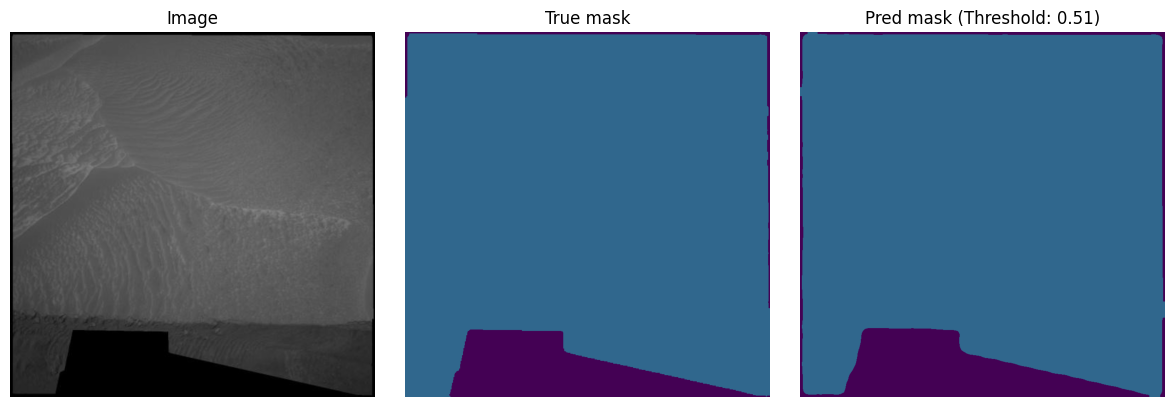

=== Sample 26 ===


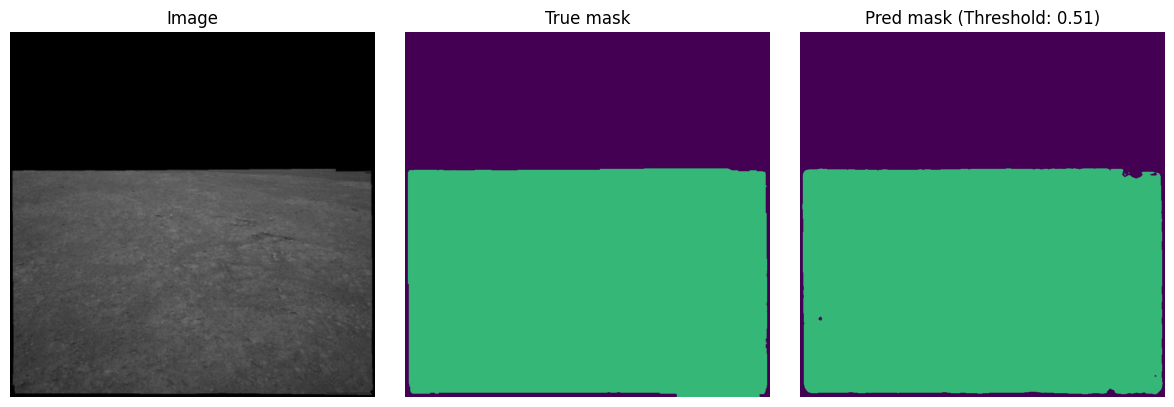

=== Sample 27 ===


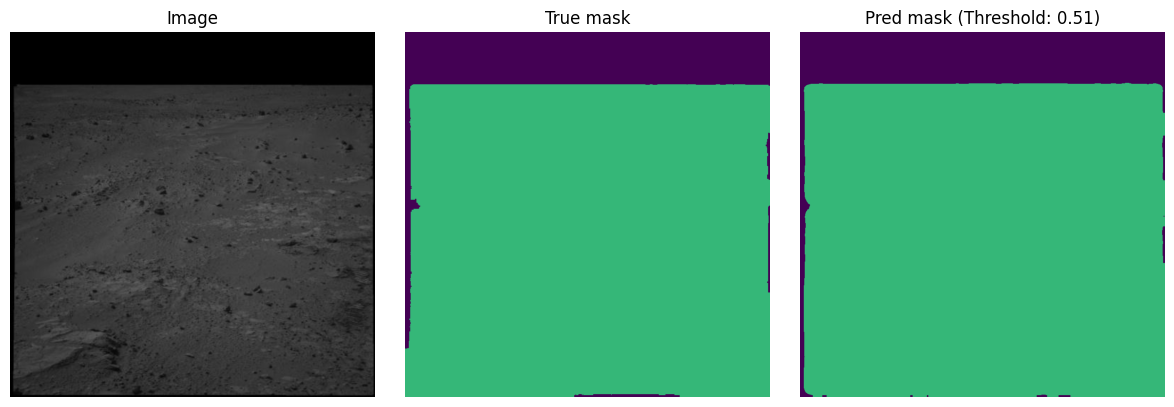

=== Sample 28 ===


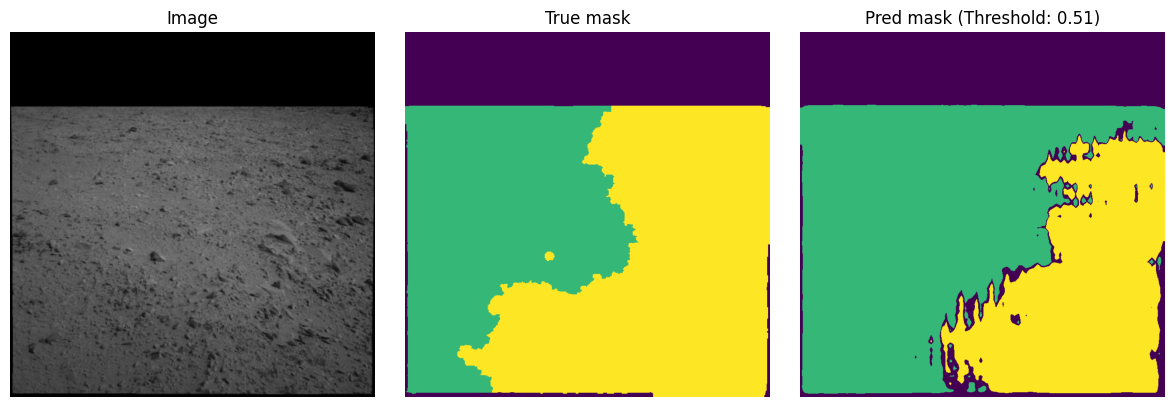

=== Sample 29 ===


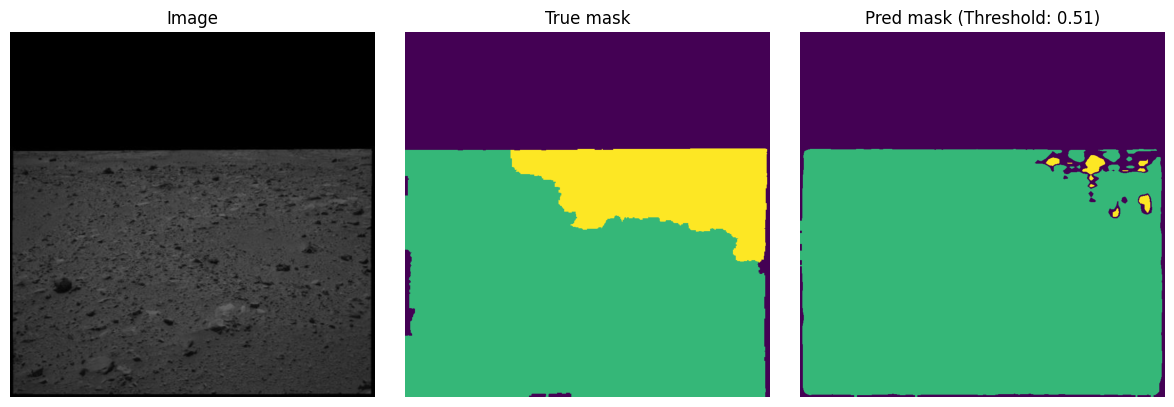

=== Sample 30 ===


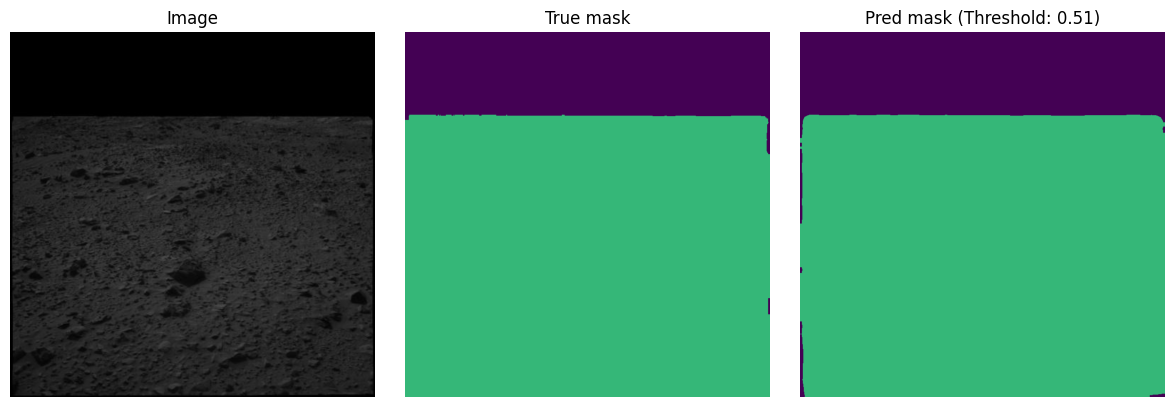

=== Sample 31 ===


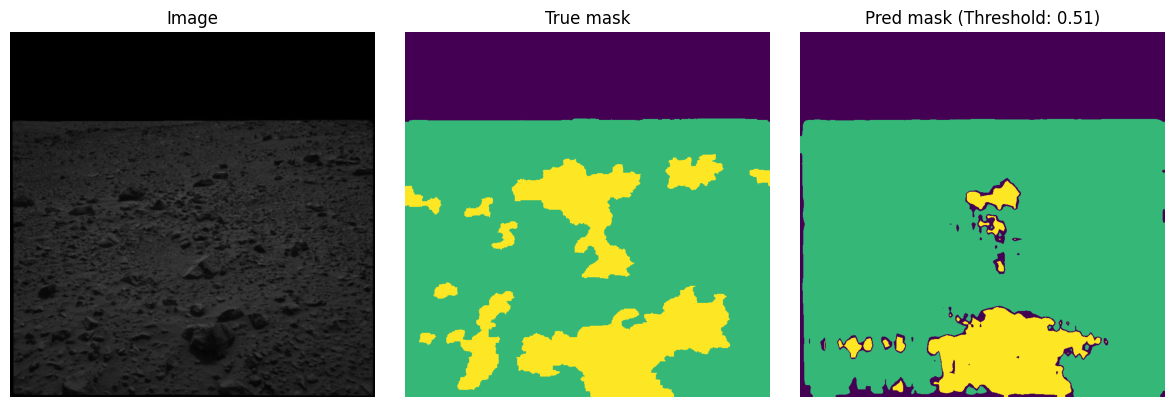

=== Sample 32 ===


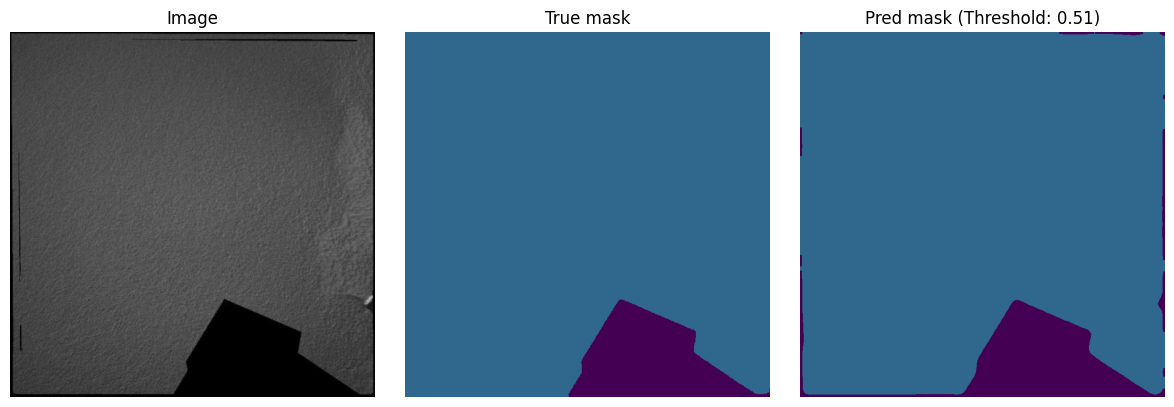

=== Sample 33 ===


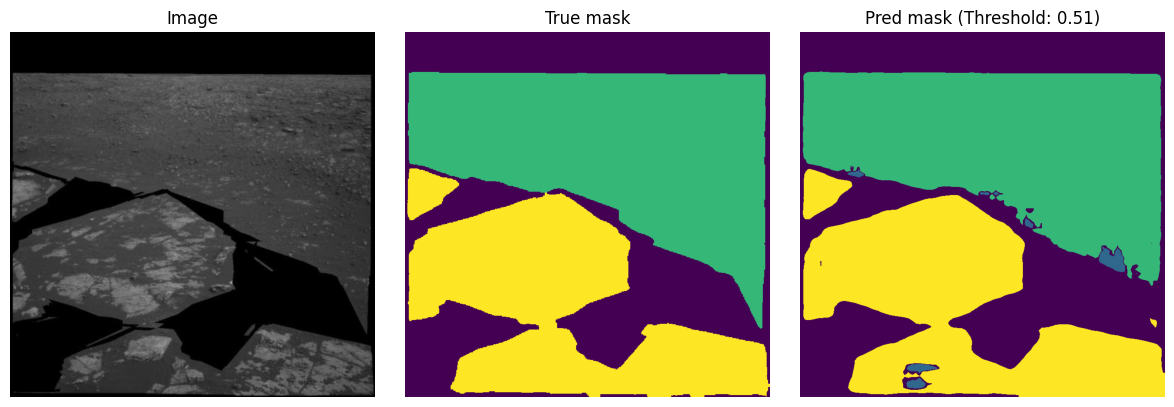

=== Sample 34 ===


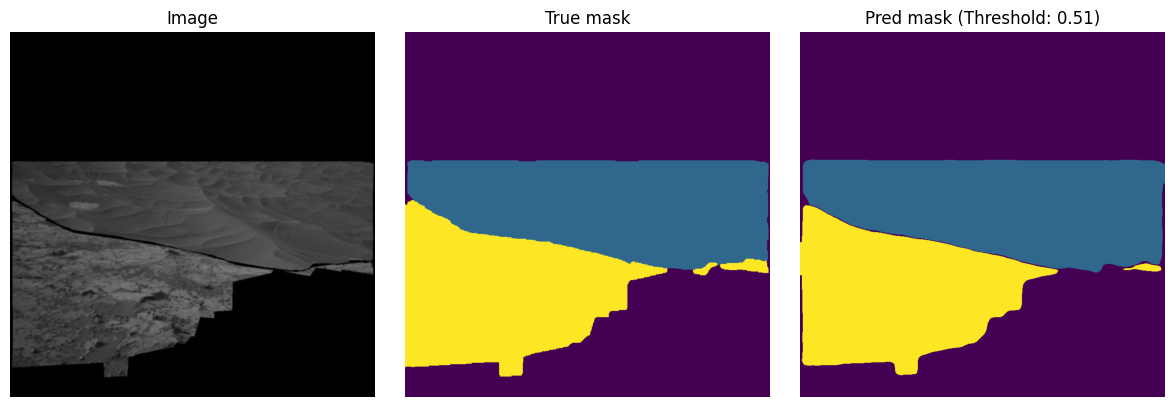

=== Sample 35 ===


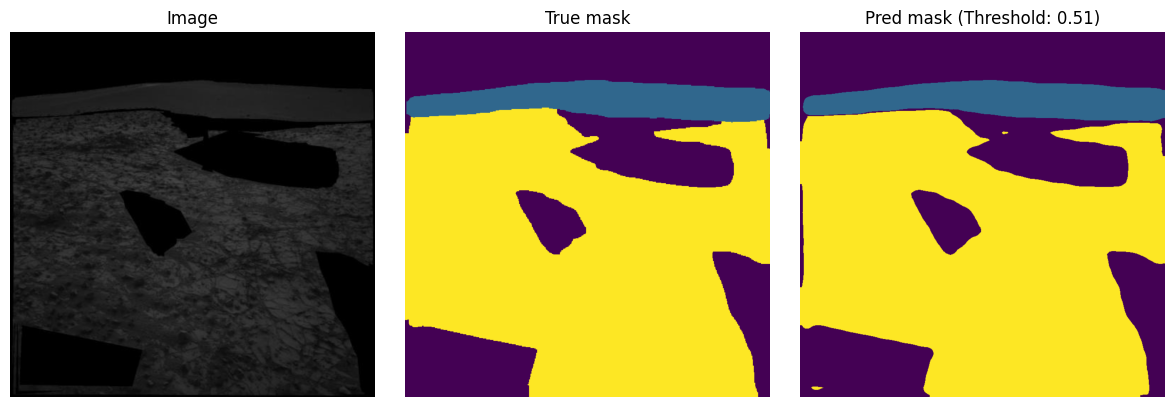

=== Sample 36 ===


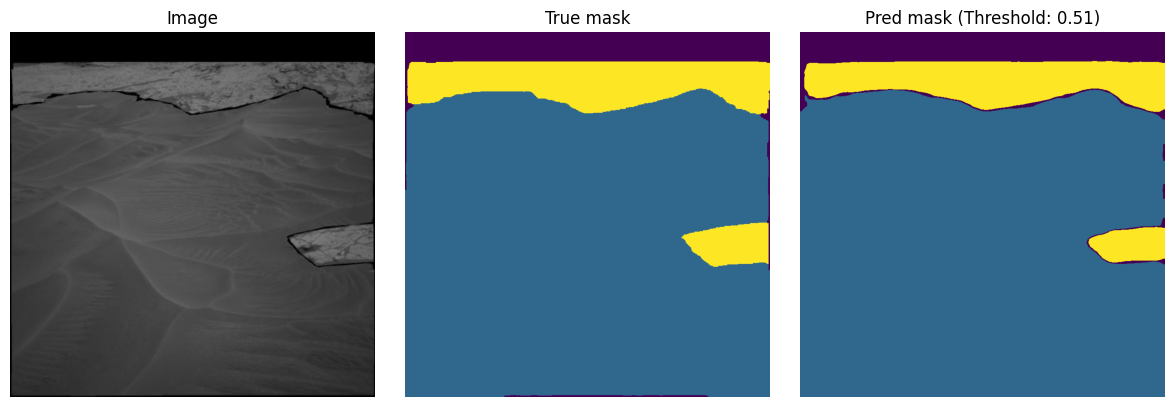

=== Sample 37 ===


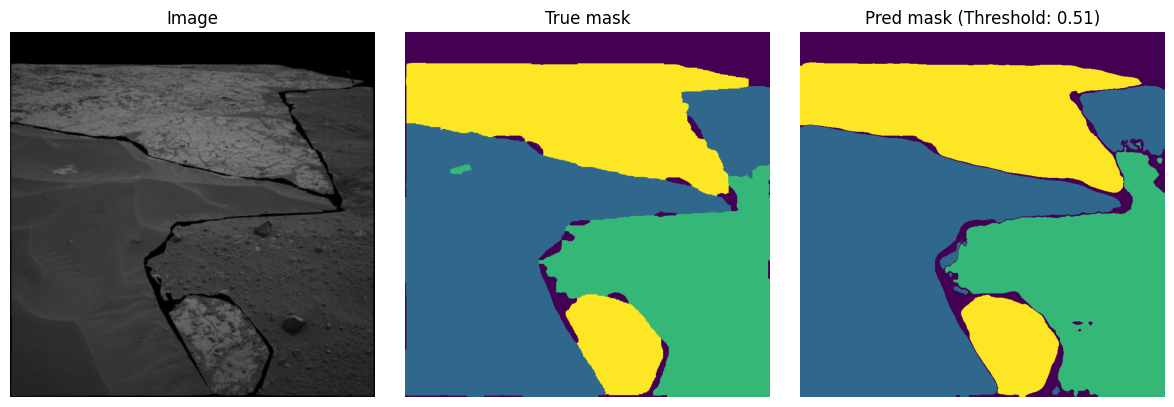

=== Sample 38 ===


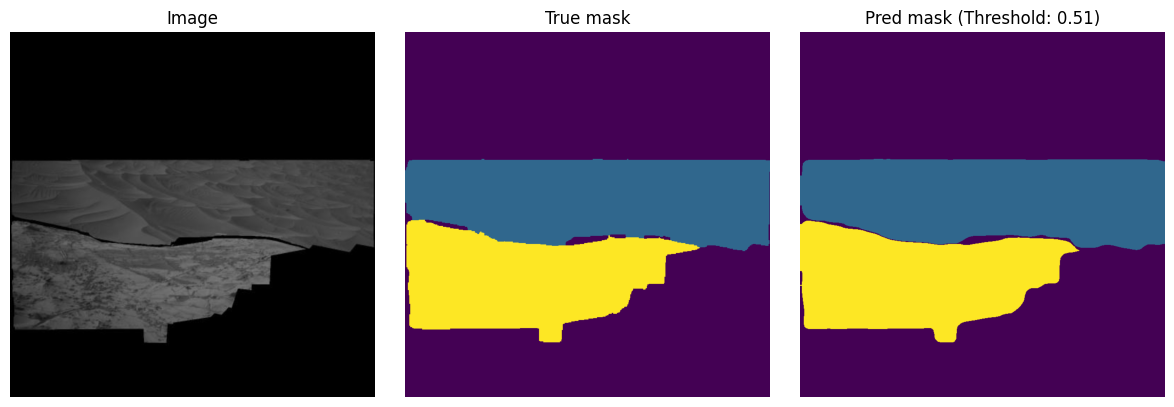

=== Sample 39 ===


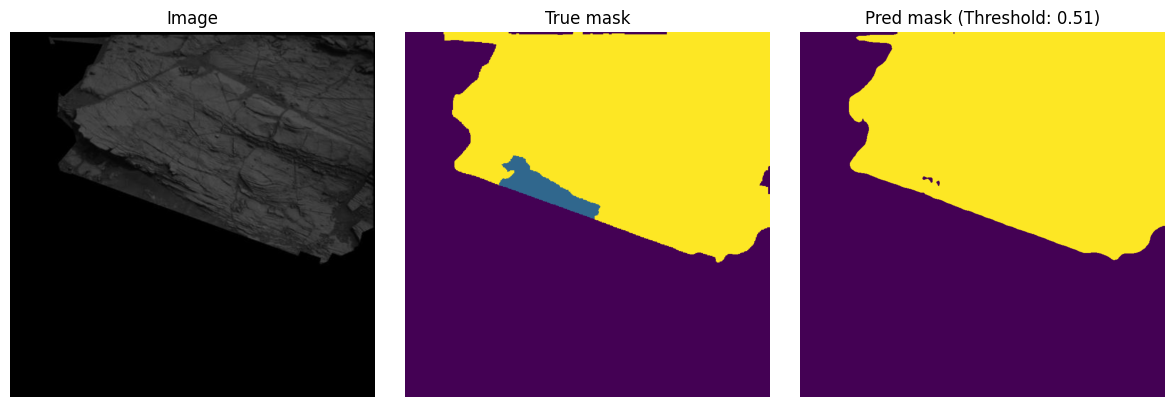

=== Sample 40 ===


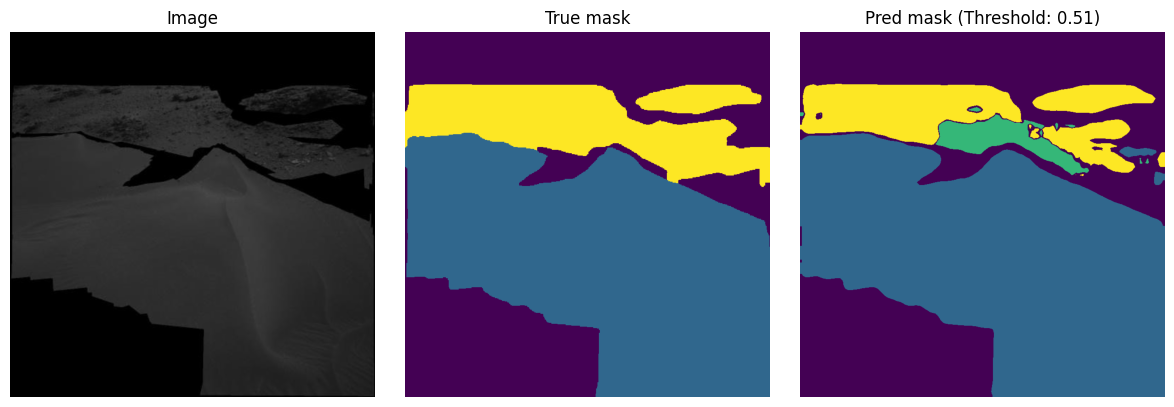

=== Sample 41 ===


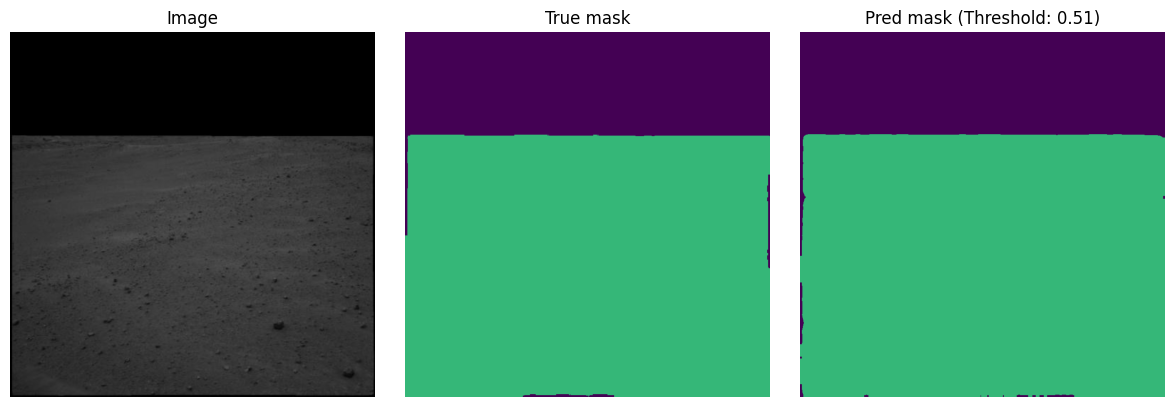

=== Sample 42 ===


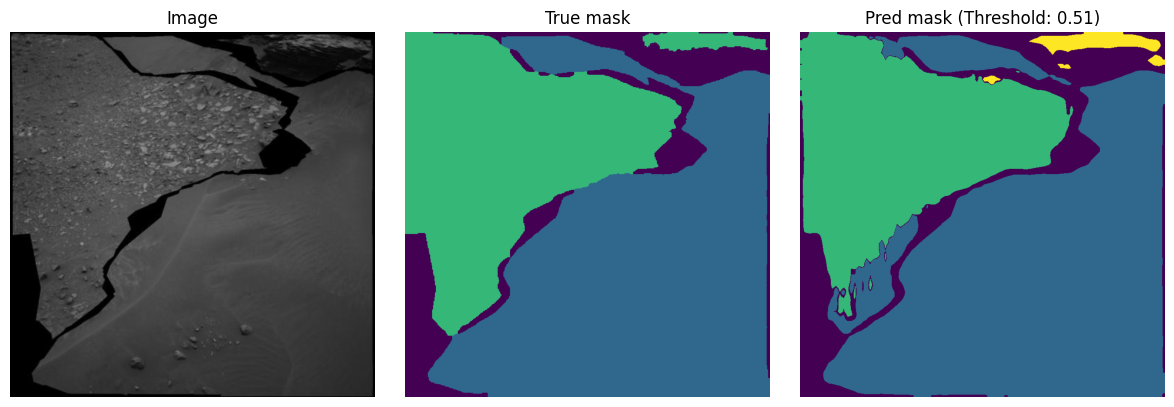

=== Sample 43 ===


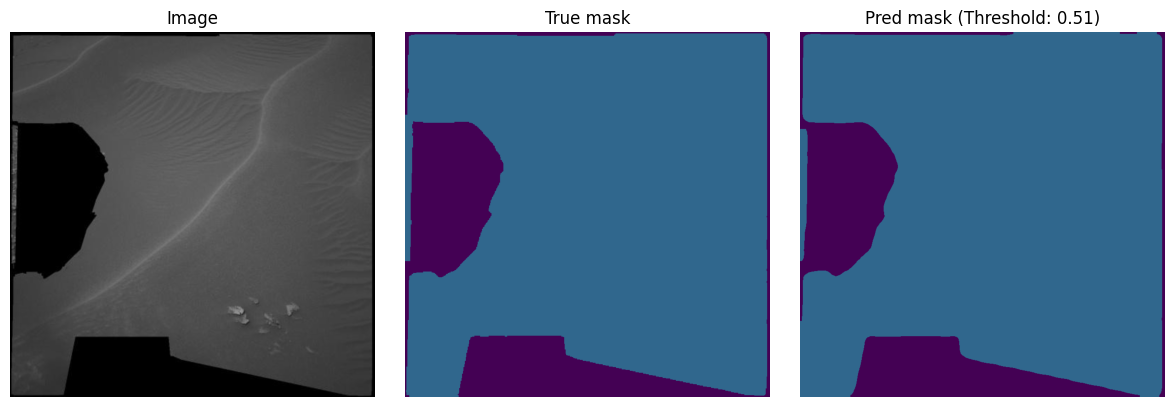

=== Sample 44 ===


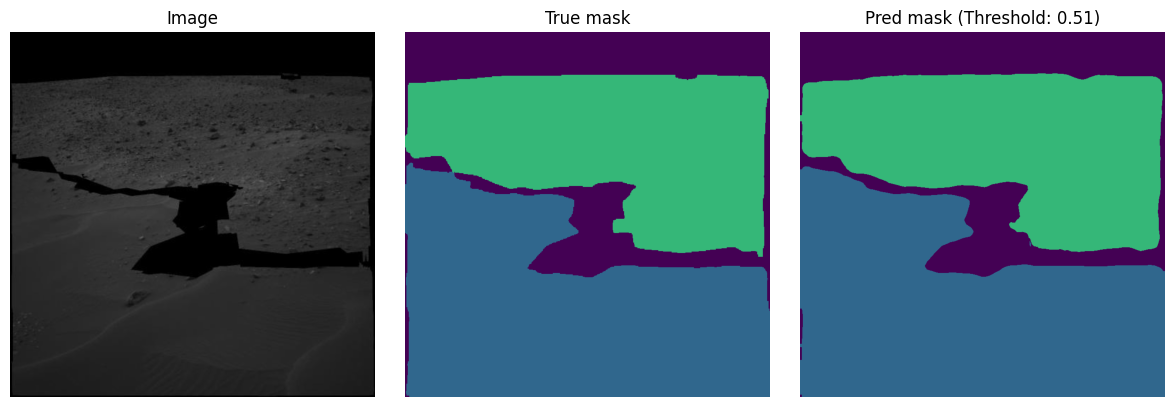

=== Sample 45 ===


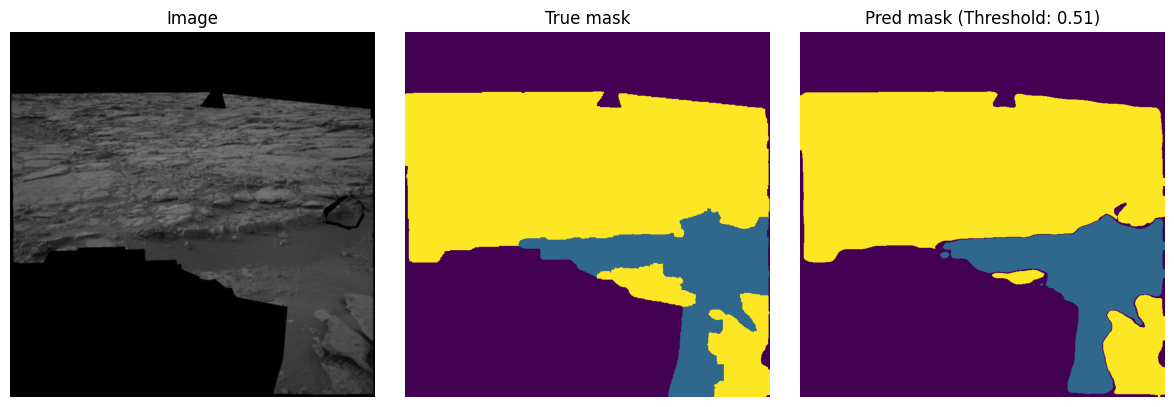

=== Sample 46 ===


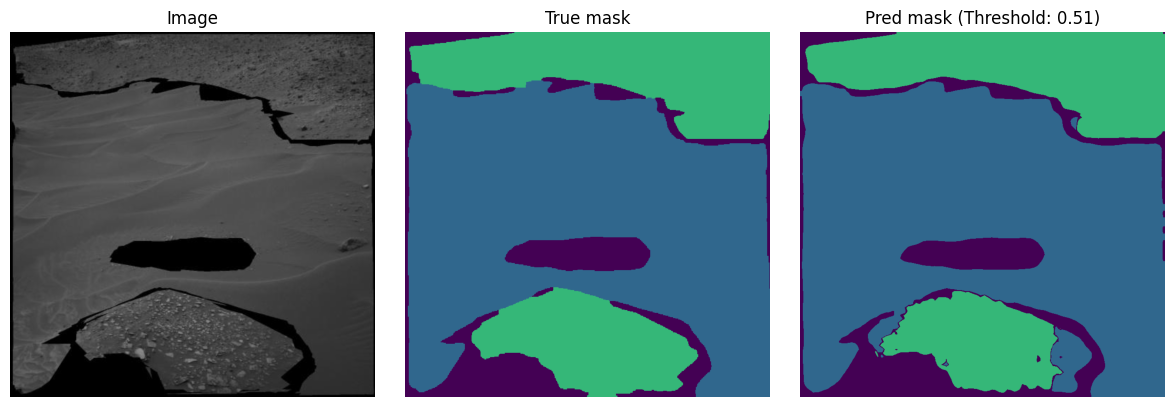

=== Sample 47 ===


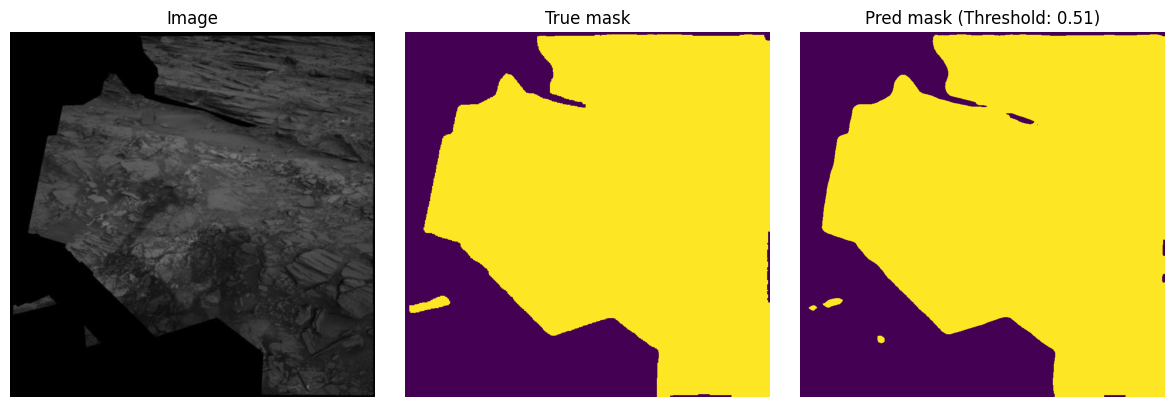

=== Sample 48 ===


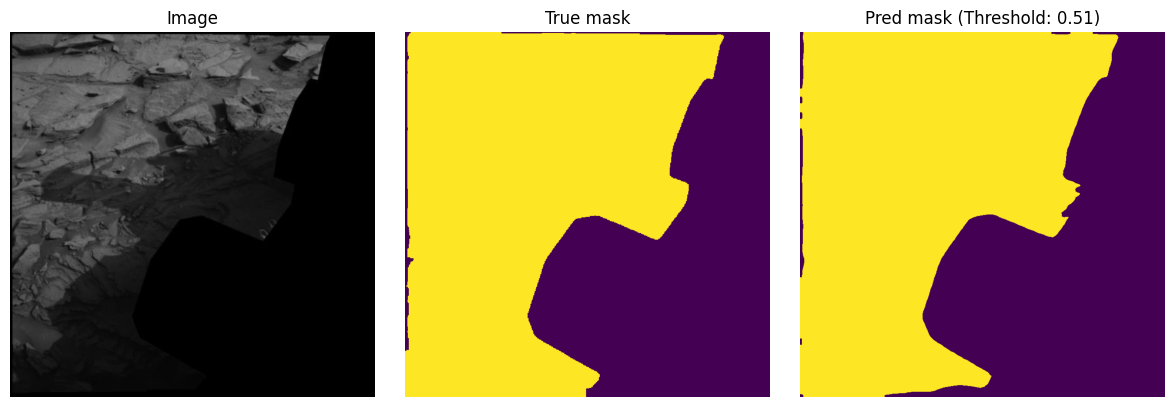

=== Sample 49 ===


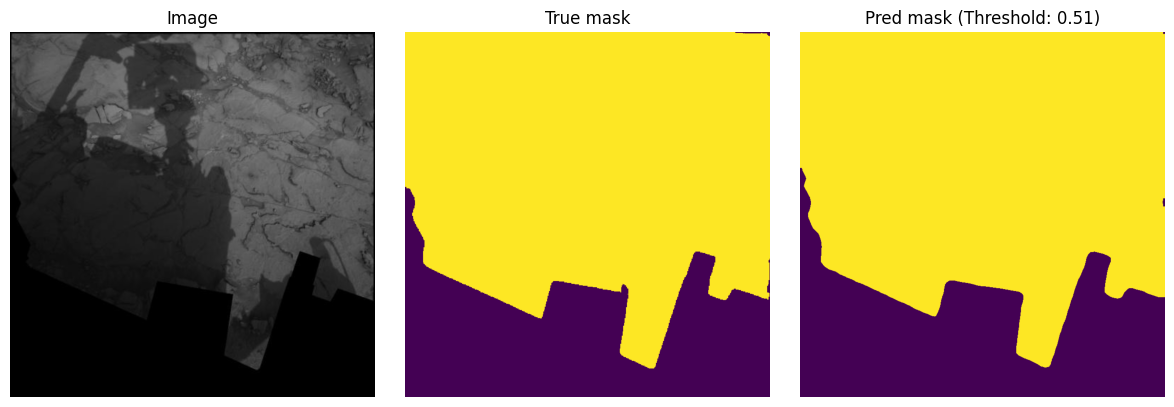

=== Sample 50 ===


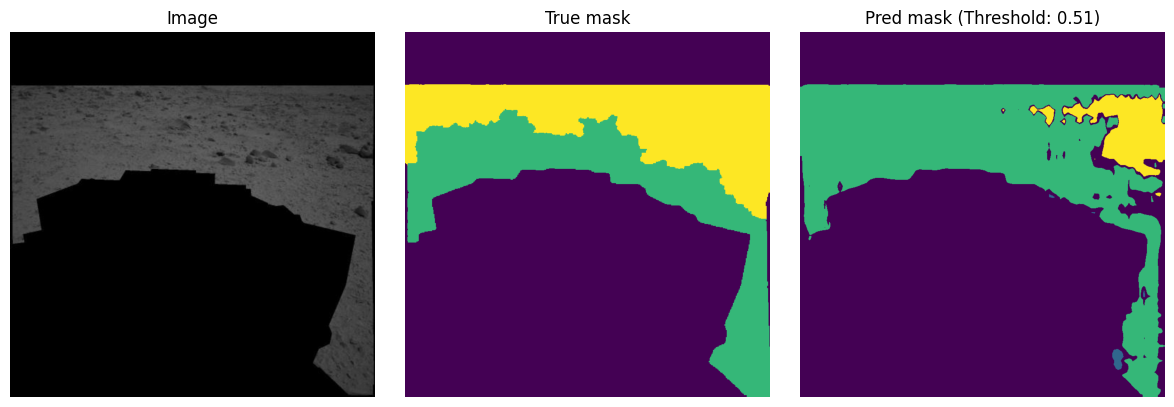

=== Sample 51 ===


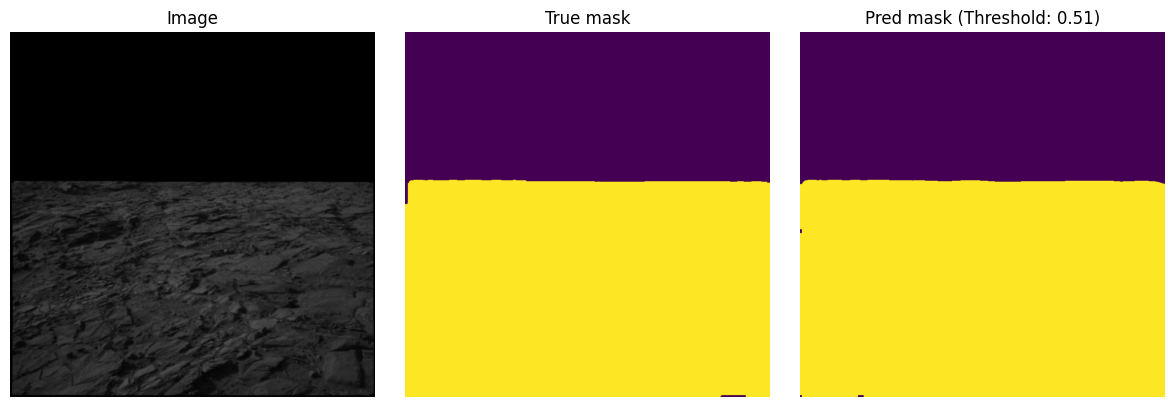

=== Sample 52 ===


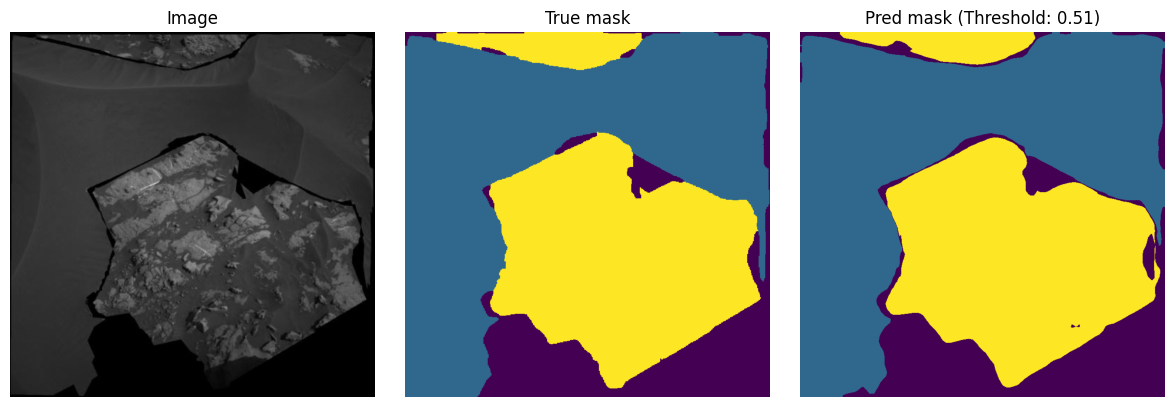

=== Sample 53 ===


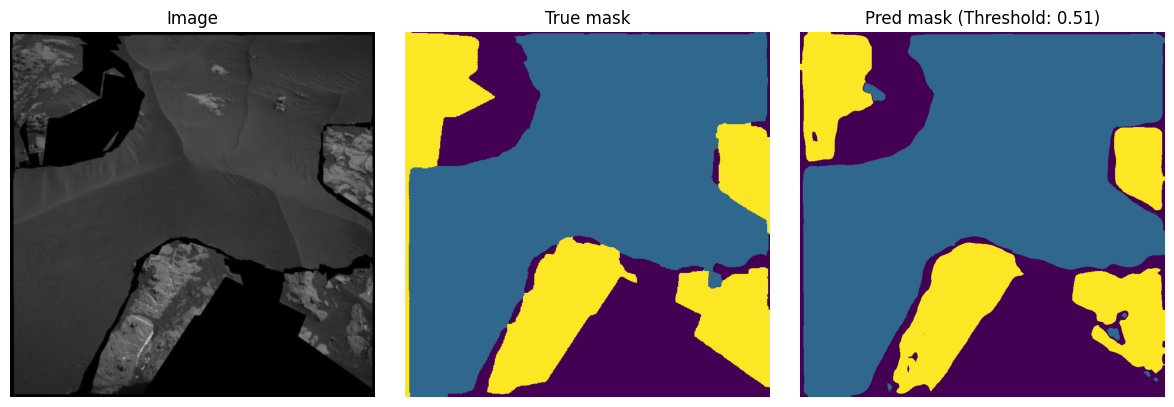

=== Sample 54 ===


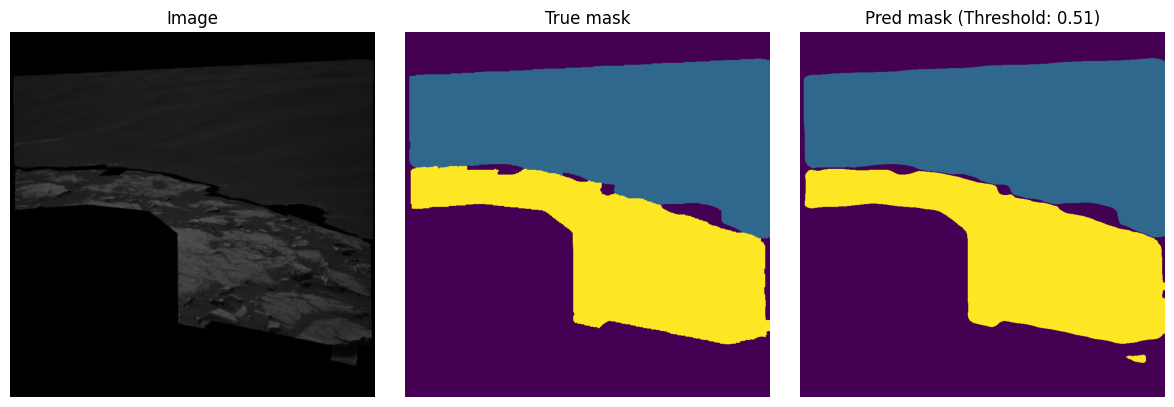

=== Sample 55 ===


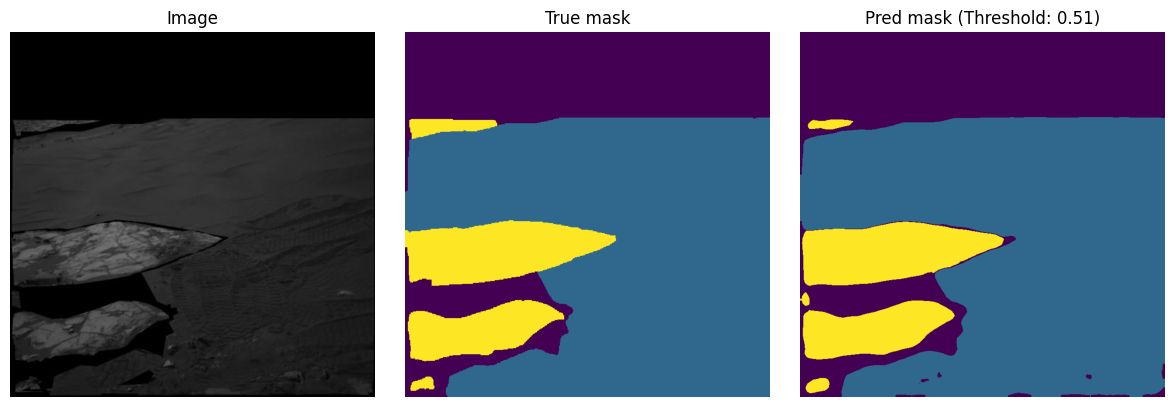

=== Sample 56 ===


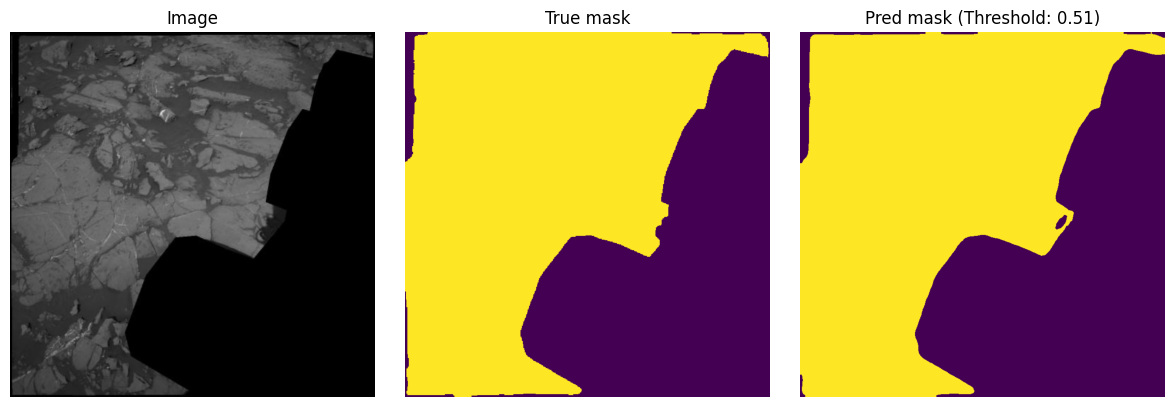

=== Sample 57 ===


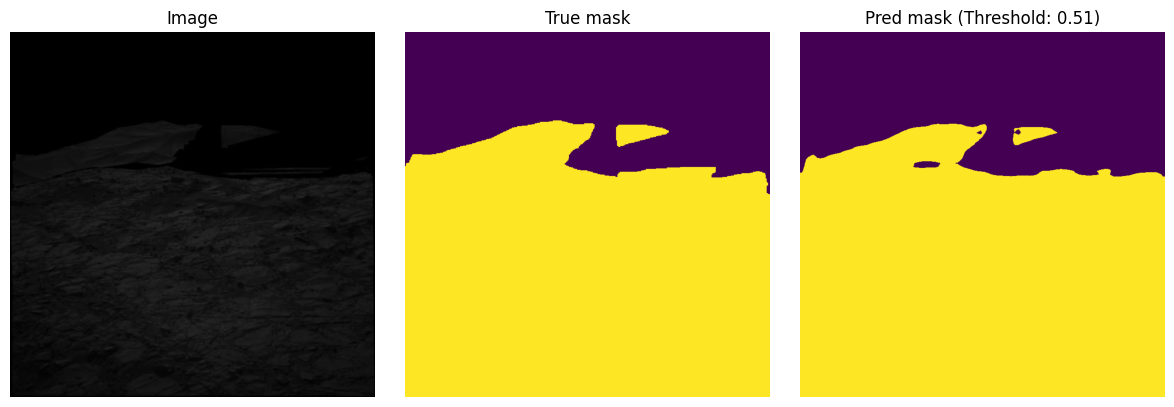

=== Sample 58 ===


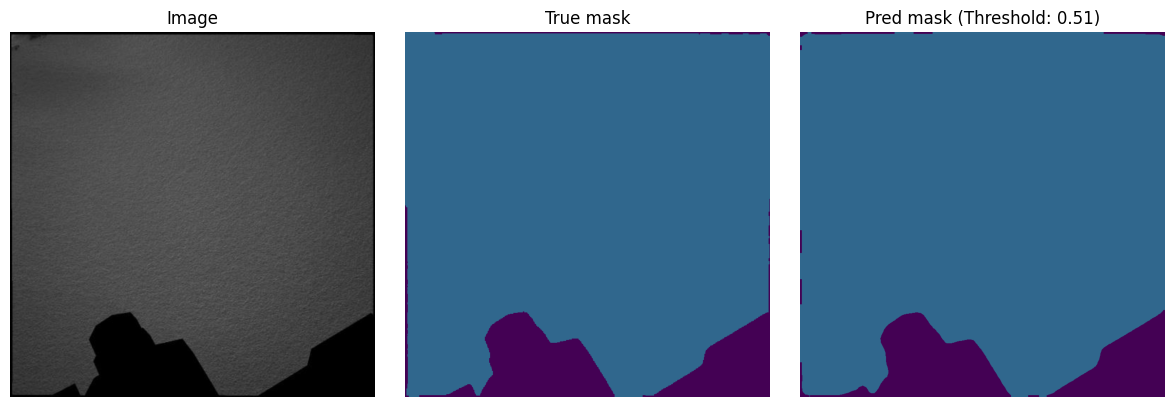

=== Sample 59 ===


KeyboardInterrupt: 

In [37]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_sample(
    model,
    dataset,
    idx=0,
    device=device,
    threshold=0.0 # Threshold for filtering low-confidence pixels in multi-class prediction
):
    model.eval()
    image, mask_true = dataset[idx] # mask_true is (H, W) with class indices
    image_batch = image.unsqueeze(0).to(device)

    output = model(image_batch)["out"]  # [1, C, H, W] where C=4

    # Apply softmax to get probabilities for each class
    softmax_output = torch.softmax(output, dim=1) # (1, 4, H, W)

    # Get the predicted class for each pixel
    pred_classes = torch.argmax(softmax_output, dim=1) # (1, H, W)
    # Get the probability of the predicted class for each pixel
    pred_probs, _ = torch.max(softmax_output, dim=1) # (1, H, W)

    # Convert to numpy
    pred_mask_np = pred_classes[0].cpu().numpy()
    pred_probs_np = pred_probs[0].cpu().numpy()

    # Apply threshold: set pixels with confidence below threshold to class 0 (background/unclassified)
    pred_mask_np[pred_probs_np < threshold] = 0

    # in numpy
    img_np = image.permute(1,2,0).cpu().numpy()
    img_vis = img_np * 0.5 + 0.5        # return to [0,1] range
    img_vis = np.clip(img_vis, 0, 1)

    true_np = mask_true.cpu().numpy() # mask_true is already (H, W)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(img_vis)
    axs[0].set_title("Image")
    # Using 'viridis' colormap for multi-class masks
    axs[1].imshow(true_np, cmap="viridis", vmin=0, vmax=3)
    axs[1].set_title("True mask")
    axs[2].imshow(pred_mask_np, cmap="viridis", vmin=0, vmax=3)
    axs[2].set_title(f"Pred mask (Threshold: {threshold:.2f})") # Show applied threshold
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# full_ds is already limited to 'n' images (which is 100)
full_ds = IndexedRoadDataset(base_dataset, list(range(n)), val_transform)

# User-definable threshold for pixel-wise confidence in predicted mask
visualization_threshold = 0.51 # Only show predicted class for pixels with confidence >= 0.5

for i in range(len(full_ds)):
    print(f"=== Sample {i} ===")
    visualize_sample(
        model,
        full_ds,
        idx=i,
        threshold=visualization_threshold
    )

# Task
Apply a carefully selected set of data augmentations, including horizontal/vertical flips, rotations, shifts, and brightness/contrast adjustments, to the `train_transform` in the `IndexedRoadDataset` class to enhance data diversity and model robustness.

## Reintroduce Data Augmentations

### Subtask:
Add a carefully selected set of data augmentations (e.g., horizontal/vertical flips, rotations, shifts, brightness/contrast adjustments) to the `train_transform` to increase the diversity of the training data and improve model robustness. We will avoid excessive augmentations that might distort the images too much for the task.


**Reasoning**:
The subtask requires reintroducing specific data augmentations to the `train_transform` defined in the notebook. I will modify the existing code cell (`4IxqAQ3t3jqk`) to include these augmentations.



## Implement Learning Rate Scheduler

### Subtask:
Add a learning rate scheduler (e.g., ReduceLROnPlateau, CosineAnnealingLR) to the training loop. This will dynamically adjust the learning rate during training, which can help achieve better convergence and avoid getting stuck in local minima.


**Reasoning**:
To implement the learning rate scheduler, I need to first import `ReduceLROnPlateau` and instantiate it after the optimizer. This will be done by modifying the code cell where the optimizer is currently defined.



**Reasoning**:
Now that the scheduler has been initialized, I need to modify the training loop to incorporate the `scheduler.step()` call after the validation loss is calculated, as per the instructions. This will dynamically adjust the learning rate based on the validation loss.



## Final Task

### Subtask:
Summarize the applied performance improvements and evaluate their impact on the model's training and validation metrics.


## Summary:

### Data Analysis Key Findings

*   **Data Augmentation Implementation**: A set of data augmentations, including horizontal flips, vertical flips, 90-degree rotations, affine transformations (for scaling, translating, and rotating), and random brightness/contrast adjustments, was successfully integrated into the `train_transform` of the `IndexedRoadDataset` class. This aims to enhance data diversity and model robustness.
*   **Warning Resolution for Augmentation**: An initial `UserWarning` related to `A.ShiftScaleRotate` was addressed by replacing it with `A.Affine`. The `A.Affine` parameters (`scale=(0.9, 1.1)`, `translate_percent=(0.0625, 0.0625)`, `rotate=(-45, 45)`) were chosen to replicate the functionality of the deprecated `ShiftScaleRotate`.
*   **Learning Rate Scheduler Integration**: A `ReduceLROnPlateau` learning rate scheduler was successfully implemented with `mode='min'`, `factor=0.5`, and `patience=3`. This scheduler is designed to dynamically reduce the learning rate by half if the validation loss does not improve for three consecutive epochs.
*   **Initial Learning Rate Stability**: During the initial 7 epochs of monitoring, the learning rate remained constant at 0.000200, indicating that the conditions for reducing the learning rate (i.e., validation loss not improving for 3 epochs) had not yet been met.

### Insights or Next Steps

*   The implemented data augmentations and learning rate scheduler are crucial steps towards improving model generalization and training efficiency. The successful resolution of the `UserWarning` ensures a cleaner and more stable training pipeline.
*   The next critical step is to execute a full training run with these applied performance improvements. This will allow for a comprehensive evaluation of their impact on the model's training convergence, validation loss, and overall performance metrics.
